# Import Required Libraries

In [39]:
import sklearn
import geopandas
import pandas as pd
import folium
import geopy
import xgboost
import lightgbm
import optuna
import ee
import reverse_geocoder as rg

modules = [sklearn, geopandas, pd, folium, geopy, xgboost, lightgbm, optuna, ee, rg]

for module in modules:
    try:
        version = module.__version__
    except AttributeError:
        version = "Not available"
    print(f"{module.__name__}: {version}")

sklearn: 1.3.1
geopandas: 0.13.2
pandas: 1.5.3
folium: 0.14.0
geopy: 2.4.0
xgboost: 1.7.5
lightgbm: 3.3.5
optuna: 3.2.0
ee: 0.1.368
reverse_geocoder: Not available


In [1]:
#!pip install reverse_geocoder
#!pip install geopy

In [2]:
from sklearn import metrics,model_selection,preprocessing,linear_model,ensemble,decomposition,tree
from sklearn.metrics import mean_squared_error,mean_absolute_error, roc_auc_score,f1_score,roc_curve,accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler,PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split, KFold ,GridSearchCV
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from catboost import CatBoostRegressor,CatBoostClassifier
from lightgbm import LGBMRegressor,LGBMClassifier
from xgboost import XGBRegressor,XGBClassifier
import geopandas as gpd
import pandas as pd

from geopy.geocoders import Nominatim

import gc,itertools, pickle, re,time,warnings
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
from random import choice, choices
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
#pip install pandas-profiling
import pandas_profiling
import seaborn as sns
%matplotlib inline
import numpy as np
import os 

from functools import reduce
from tqdm import tqdm
from itertools import cycle
from matplotlib_venn import venn2

import xgboost as xgb
import lightgbm as lgb
from scipy import stats
from functools import reduce
seed = 777
import random
random.seed(seed)
np.random.seed(seed)
plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]


import reverse_geocoder as rg
import folium
import geopandas as gpd
from shapely.geometry import Point

In [3]:
# train datas
train_afghan=pd.read_csv(r"D:\ZINDI\TABULAR\GEO-AI Challenge for Cropland Mapping by ITU\train_afghan_2.csv")
train_sudan=pd.read_csv(r"D:\ZINDI\TABULAR\GEO-AI Challenge for Cropland Mapping by ITU\train_sudan_2.csv")
train_iran=pd.read_csv(r"D:\ZINDI\TABULAR\GEO-AI Challenge for Cropland Mapping by ITU\train_iran_2.csv")

# test datas
test_afghan=pd.read_csv(r"D:\ZINDI\TABULAR\GEO-AI Challenge for Cropland Mapping by ITU\test_afghan_2.csv")
test_sudan=pd.read_csv(r"D:\ZINDI\TABULAR\GEO-AI Challenge for Cropland Mapping by ITU\test_sudan_2.csv")
test_iran=pd.read_csv(r"D:\ZINDI\TABULAR\GEO-AI Challenge for Cropland Mapping by ITU\test_iran_2.csv")

# combine all
train=pd.concat([train_afghan,train_sudan,train_iran])
test=pd.concat([test_afghan,test_sudan,test_iran])
print(train.shape, test.shape)
#train.head()

(1500, 16) (1500, 15)


In [4]:
display(train.head(2),
        test.head(2))

id        lat        lon  target           B1           B2  \
0  ID_SJ098E7S2SY9  34.162491  70.763668       0   881.000000  1236.000000   
1  ID_I5DS1NLN2WM8  34.251435  70.359562       1  5171.916667  5129.333333   

            B3           B4           B5           B6           B7  \
0  1721.833333  2106.833333  2452.666667  2547.166667  2696.000000   
1  4729.166667  4457.833333  4732.416667  4976.833333  5095.166667   

            B8          B8A           B9          B11          B12  
0  2643.500000  2798.500000  2778.166667  3623.166667  3391.333333  
1  5083.416667  4927.666667  7660.666667  3783.666667  3136.083333

id        lat        lon           B1           B2  \
0  ID_9ZLHTVF6NSU7  34.254835  70.348699  3730.666667  3153.666667   
1  ID_B2WO8GOJOMY1  34.305928  70.389446  1344.916667  2382.916667   

            B3           B4           B5           B6           B7  \
0  3165.000000  2861.833333  3276.833333  4073.500000  4448.166667   
1  2638.166667  2673.833333  2507.166667  3399.333333  3802.416667   

            B8          B8A           B9          B11          B12  
0  4458.666667  4472.666667  6850.166667  2821.166667  2412.750000  
1  3891.000000  3830.750000  4270.583333  2935.583333  2343.583333

# DATA CLEANING

In [5]:
#No missing values
#train.isna().sum(),test.isna().sum()

In [6]:
def rename_columns(df):
    df.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)
    return df
train = rename_columns(train)
test = rename_columns(test)

# FEATURE ENGINEERING

In [7]:
def location(df) :
    #data = pd.concat([train,test])
    #df.lat, df.lon = round(df.lat, 2), round(df.lon, 2)
    df['location'] = [str(x) + '_' + str(y) for x, y in zip(round(df.lat, 2), round(df.lon, 2))]
    
    #sort the datasets based on lcation year and week no
    df = df.sort_values(by = ['location'])
    return df
train=location(train)
test=location(test)
test.head(3)

id        lat        lon           b1           b2  \
393  ID_OV27436VT055  14.113881  33.285725  2245.611111  2300.291667   
402  ID_8V2J64GG6RLV  14.111635  33.312585  2270.319444  2223.430556   
332  ID_DB1QADY40412  14.107323  33.310339  2300.027778  2287.958333   

              b3           b4           b5           b6           b7  \
393  2516.333333  2748.722222  3039.333333  3056.277778  3126.361111   
402  2342.458333  2434.222222  2700.013889  2742.902778  2795.152778   
332  2485.180556  2691.347222  2988.055556  3018.152778  3088.722222   

              b8          b8a           b9          b11          b12  \
393  3199.625000  3218.222222  4552.638889  3133.097222  2702.597222   
402  2824.611111  2853.861111  4228.819444  2606.611111  2236.958333   
332  3125.847222  3180.236111  4544.527778  2951.666667  2513.180556   

        location  
393  14.11_33.29  
402  14.11_33.31  
332  14.11_33.31

In [8]:
def get_country(df):
    afghan=df.loc[(df['lon']>55)&(df['lon']<100)]
    afghan["country"]="afghan"
    iran=df.loc[(df['lon']>45)&(df['lon']<55)]  
    iran["country"]="iran"
    sudan=df.loc[(df['lon']>30)&(df['lon']<40)]  
    sudan["country"]="sudan"
    df=pd.concat([sudan,iran,afghan],axis=0)

    return df
train=get_country(train)
test=get_country(test)
train.head()

id        lat        lon  target           b1           b2  \
181  ID_JRBSKS8MYPU6  14.113252  33.314202       0  2268.375000  2224.791667   
183  ID_K5SS5L8BA8TF  14.110377  33.333426       1  2249.958333  2350.930556   
447  ID_KM39ZSIZCC5A  14.112084  33.347350       0  2336.791667  2297.125000   
79   ID_ERVODRIN6NQJ  14.119091  33.237935       0  2451.972222  2420.555556   
327  ID_6U9MY0ASQUWB  14.124840  33.435654       1  1928.444444  1975.388889   

              b3           b4           b5           b6           b7  \
181  2340.222222  2435.513889  2708.763889  2766.319444  2819.763889   
183  2502.277778  2600.402778  2938.041667  3190.569444  3322.305556   
447  2414.944444  2499.263889  2767.319444  2806.583333  2857.069444   
79   2757.000000  3158.361111  3454.416667  3586.111111  3696.638889   
327  2102.708333  2135.930556  2484.750000  2795.208333  2926.666667   

              b8          b8a           b9          b11          b12  \
181  2854.416667  2885.000000  4256.152778  2518.416667  2122.152778   
183  3474.263889  3406.291667  4688.069444  2635.597222  2086.708333   
447  2905.847222  2910.013889  4285.972222  2490.958333  2141.861111   
79   3751.083333  3752.722222  5214.083333  3895.416667  3418.305556   
327  3091.750000  2999.819444  4251.500000  2288.694444  1822.555556   

        location country  
181  14.11_33.31   sudan  
183  14.11_33.33   sudan  
447  14.11_33.35   sudan  
79   14.12_33.24   sudan  
327  14.12_33.44   sudan

In [9]:
def geocoder(data):
    '''
    input: dataframe containing Latitude(lat) and longitude(lon) coordinates
    output: dataframe with additional columns for place information
    '''
    # Convert DataFrame to a list of tuples
    coordinates = list(zip(data['lat'], data['lon']))
    
    results = rg.search(coordinates)  # default mode = 2

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)

    # Rename columns to more meaningful names
    results_df.rename(columns={'name': 'place_name', 'admin1': 'state', 'admin2': 'county'}, inplace=True)

    # Concatenate the results with the original data
    data_with_places = pd.concat([data, results_df], axis=1)

    return data_with_places

# Apply the geocoder function to your train and test datasets
#print(train.index.duplicated().sum()) 
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

train = geocoder(train)
test = geocoder(test)

train.columns=train.columns[:-6:].tolist()+['lati', 'long', 'place_name', 'state', 'county', 'cc']
test.columns=test.columns[:-6:].tolist()+['lati', 'long', 'place_name', 'state', 'county', 'cc']

test.head(3)

Loading formatted geocoded file...


id        lat        lon           b1           b2  \
0  ID_OV27436VT055  14.113881  33.285725  2245.611111  2300.291667   
1  ID_8V2J64GG6RLV  14.111635  33.312585  2270.319444  2223.430556   
2  ID_DB1QADY40412  14.107323  33.310339  2300.027778  2287.958333   

            b3           b4           b5           b6           b7  \
0  2516.333333  2748.722222  3039.333333  3056.277778  3126.361111   
1  2342.458333  2434.222222  2700.013889  2742.902778  2795.152778   
2  2485.180556  2691.347222  2988.055556  3018.152778  3088.722222   

            b8          b8a           b9          b11          b12  \
0  3199.625000  3218.222222  4552.638889  3133.097222  2702.597222   
1  2824.611111  2853.861111  4228.819444  2606.611111  2236.958333   
2  3125.847222  3180.236111  4544.527778  2951.666667  2513.180556   

      location country     lati     long place_name   state county  cc  
0  14.11_33.29   sudan  14.0361  33.1712     Kinana  Sinnar         SD  
1  14.11_33.31   sudan  14.0361  33.1712     Kinana  Sinnar         SD  
2  14.11_33.31   sudan  14.0361  33.1712     Kinana  Sinnar         SD

# EDA

**MAPS**

In [10]:
# 0-afhgan,1-iran, 2-sudan
#test=test[test["country"]=="iran"]
#train=train[train["country"]=="iran"]

# Combine train and test for easy visualisation
train_coords = train.drop_duplicates(subset = ['lat', 'lon'])
test_coords = test.drop_duplicates(subset = ['lat', 'lon'])
train_coords['set_type'], test_coords['set_type'] = 'train', 'test'

all_data = pd.concat([train_coords, test_coords], ignore_index = True)
# Create point geometries

geometry = gpd.points_from_xy(all_data.lon, all_data.lat)
geo_df = gpd.GeoDataFrame(all_data[["lat", "lon", "set_type"]], geometry=geometry)

# Preview the geopandas df
geo_df.head()

lat        lon set_type                   geometry
0  14.113252  33.314202    train  POINT (33.31420 14.11325)
1  14.110377  33.333426    train  POINT (33.33343 14.11038)
2  14.112084  33.347350    train  POINT (33.34735 14.11208)
3  14.119091  33.237935    train  POINT (33.23794 14.11909)
4  14.124840  33.435654    train  POINT (33.43565 14.12484)

In [11]:
# Assuming you have a GeoDataFrame named 'geo_df' with columns 'geometry' and 'set_type'

# Create a canvas with a satellite background
all_data_map = folium.Map(prefer_canvas=True, tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', 
                          attr='Google')

# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0], set_type] for set_type, point in zip(geo_df['set_type'], 
                                                                                     geo_df.geometry)]

# Define color mapping for 'set_type'
type_color_mapping = {
    "train": "green",
    "test": "orange"
}

# Iterate through the list and add a marker for each point
for coordinates in geo_df_list:
    latitude, longitude, set_type = coordinates
    type_color = type_color_mapping.get(set_type, "blue")  # Default to blue if not found in mapping
    popup_html = f"Set: {set_type}<br>Coordinates: [{latitude:.2f}, {longitude:.2f}]"
    all_data_map.add_child(folium.CircleMarker(location=[latitude, longitude], radius=1, weight=4, zoom=10,
                                               popup=popup_html, color=type_color))

# Fit the map bounds to include all markers
all_data_map.fit_bounds(all_data_map.get_bounds())

# Display the map
all_data_map


<Axes: xlabel='lat', ylabel='lon'>

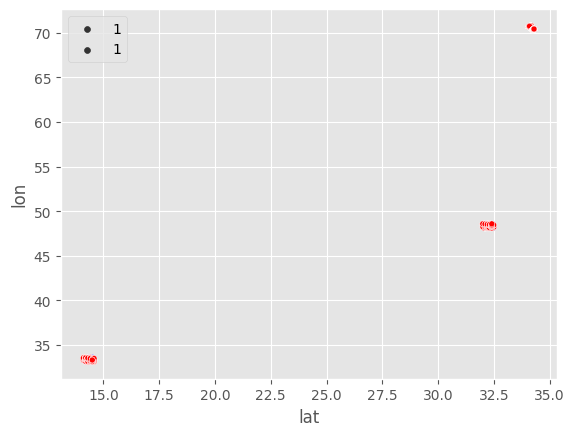

In [12]:
# plt.set_style('bmh')
sns.scatterplot(data = train,x = 'lat' ,y = 'lon', size=1,color = 'blue')
sns.scatterplot(data = test,x = 'lat' ,y = 'lon', size=1,color = 'red')

**TARGET VARIABLE**

Class share

Class 0: 50.00 %
Class 1: 50.00 %


Text(0, 0.5, 'Share (%)')

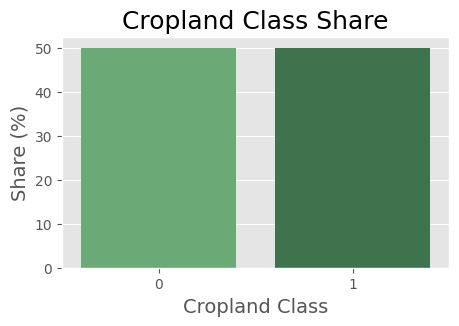

In [13]:
class_share = pd.Series(100 * train.target.value_counts(normalize=True)).sort_index()
print('Class share\n')
for i in range(0,2):
    print(f'Class {class_share.index[i]}: {class_share.iloc[i]:.2f} %')
    
fig, ax = plt.subplots(figsize=(5,3))
sns.barplot(ax=ax, x = class_share.index, y = class_share, palette='Greens_d')
plt.title('Cropland Class Share', fontsize=18)
plt.xlabel('Cropland Class', fontsize=14)
plt.ylabel('Share (%)', fontsize=14)

In [14]:
numeric_cols=[]
categorical_cols=[]

for column in [col for col in train.columns.tolist() if col not in ["id","lat","lon","lati","long"]]:
    if train[column].nunique()>30:
        numeric_cols.append(column)
    elif train[column].nunique()<30:
        categorical_cols.append(column)
print(numeric_cols)
categorical_cols

['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b8a', 'b9', 'b11', 'b12', 'location']


['target', 'country', 'place_name', 'state', 'county', 'cc']

In [18]:
if 'location' in numeric_cols:
    numeric_cols.remove('location')

print(numeric_cols)

['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b8a', 'b9', 'b11', 'b12']


**CATEGORICAL VARIABLES**

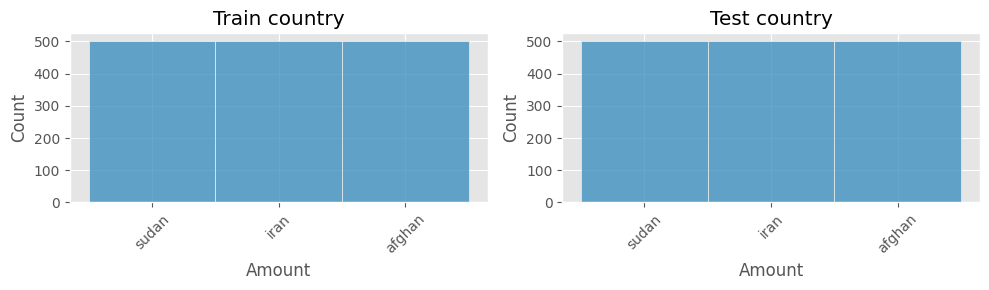

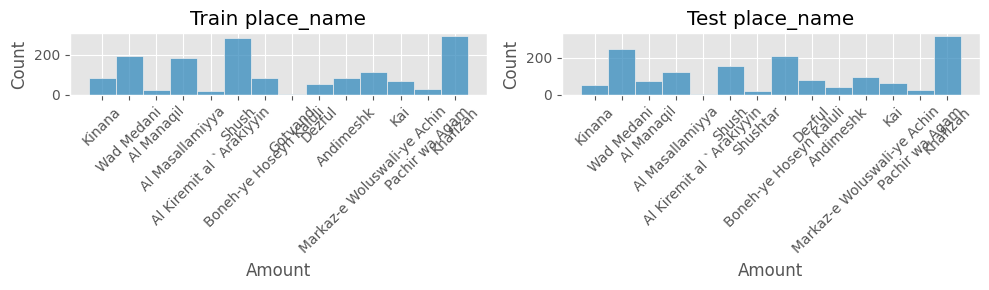

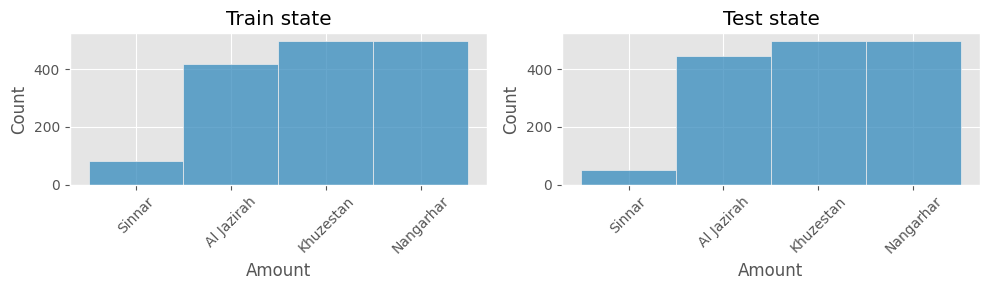

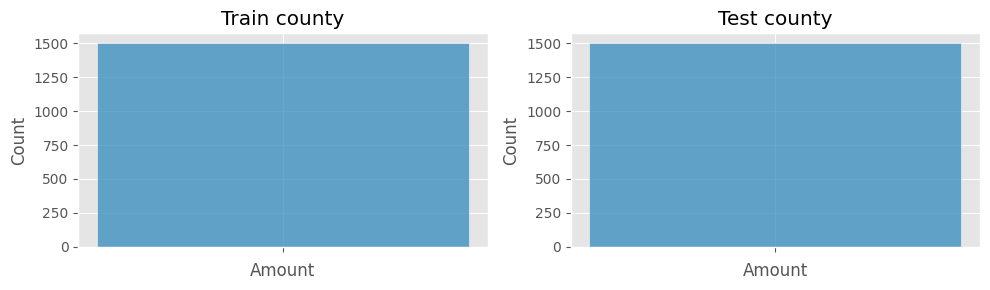

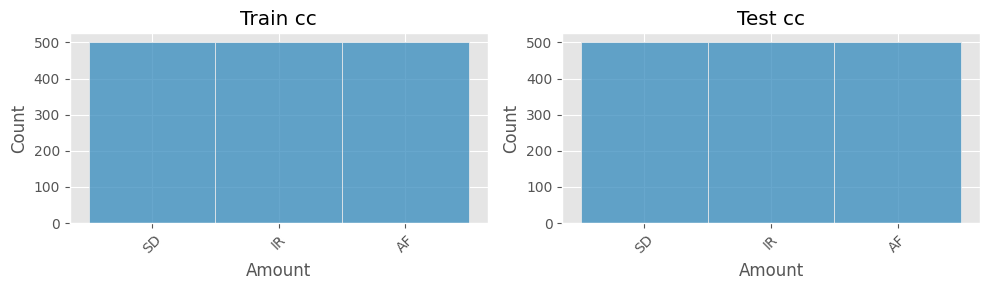

In [15]:
for column in categorical_cols:
    if column!='target':
        plt.figure(figsize=(10, 3))

        # Create a subplot for combined_df data
        plt.subplot(1, 2, 1)
        sns.histplot(train, x=column) 
        plt.title(f"Train {column}")
        plt.xlabel("Amount")
        plt.ylabel("Count")
        plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees

        # Create a subplot for test data
        plt.subplot(1, 2, 2)
        sns.histplot(test, x=column) 
        plt.title(f"Test {column}")
        plt.xlabel("Amount")
        plt.ylabel("Count")
        plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees
        plt.tight_layout()  # Adjust spacing between subplots
        plt.show()

**KDE -NUMERICAL**

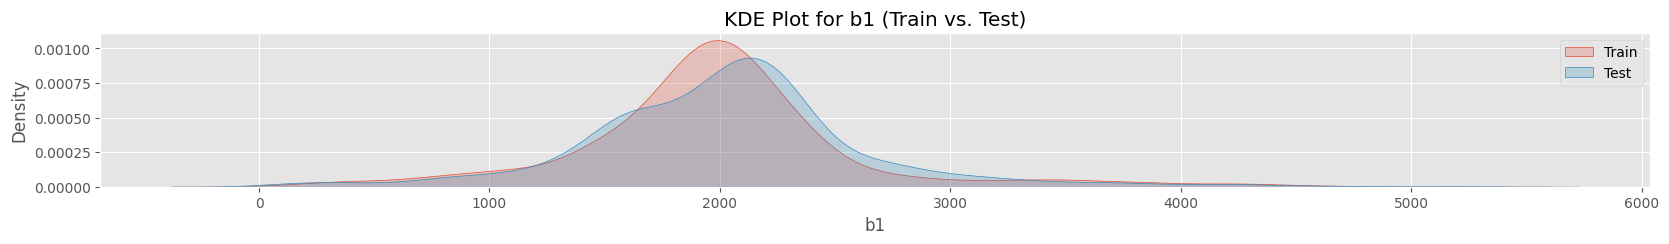

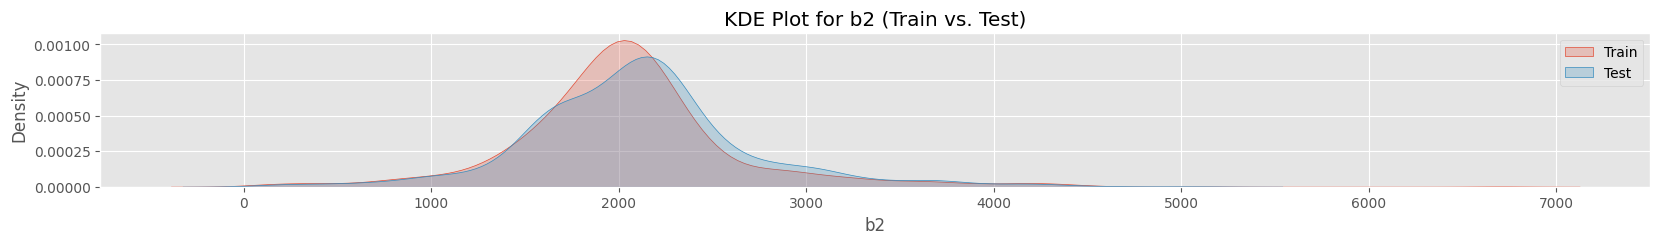

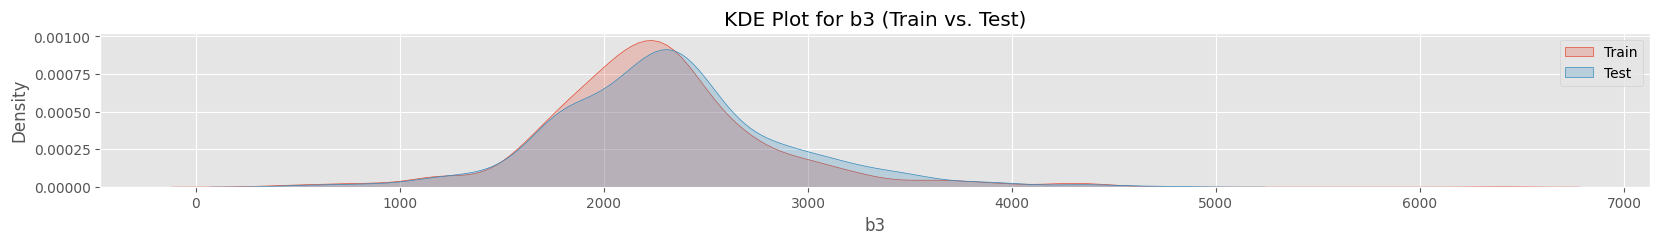

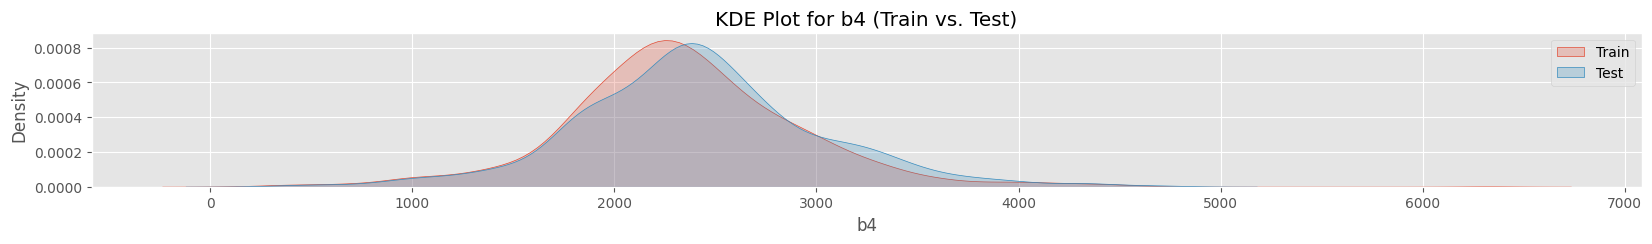

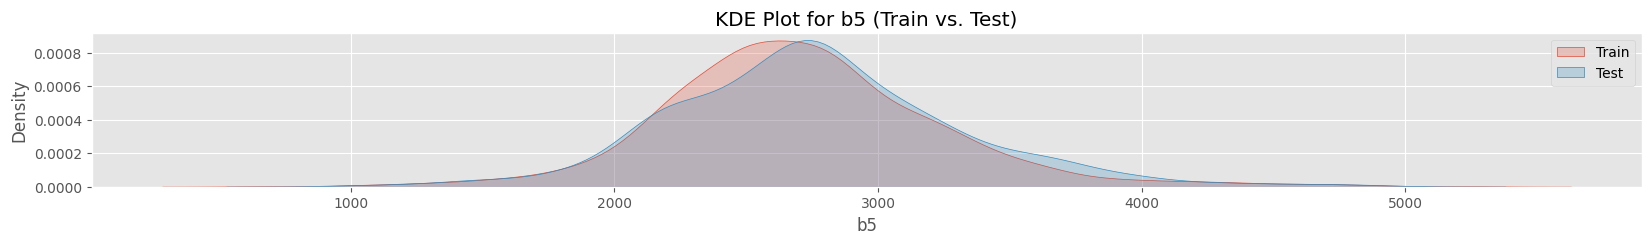

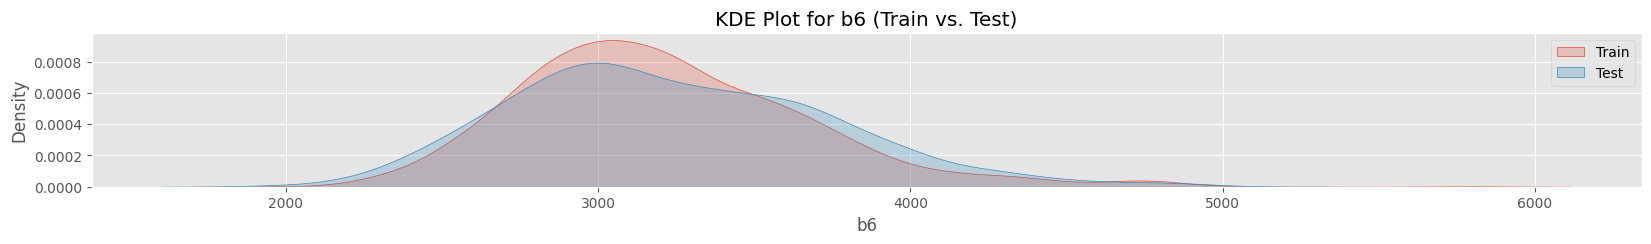

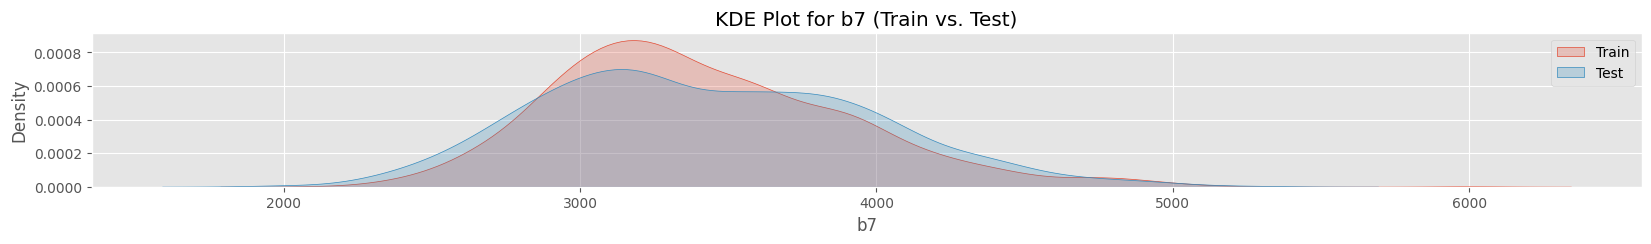

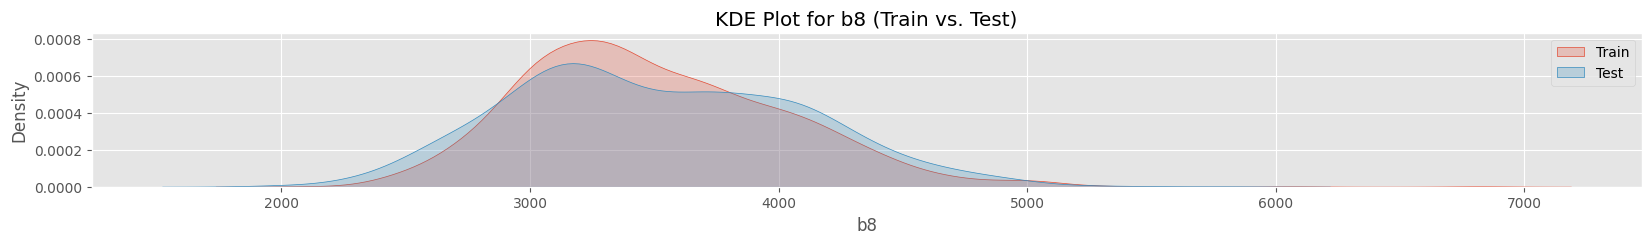

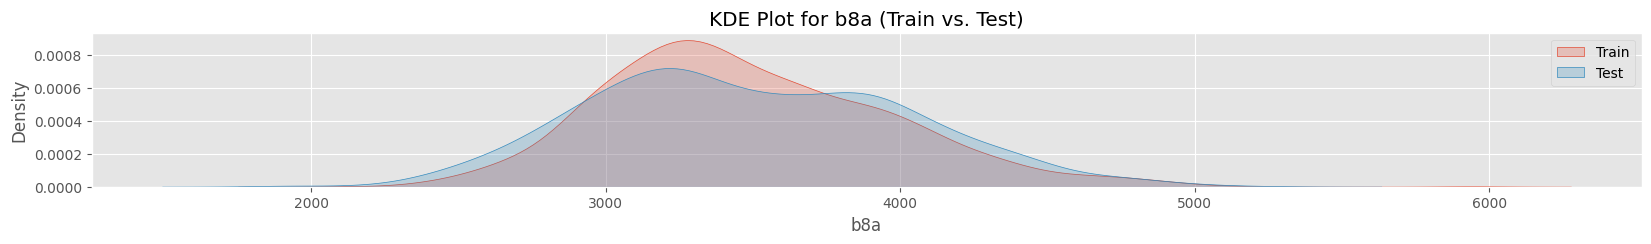

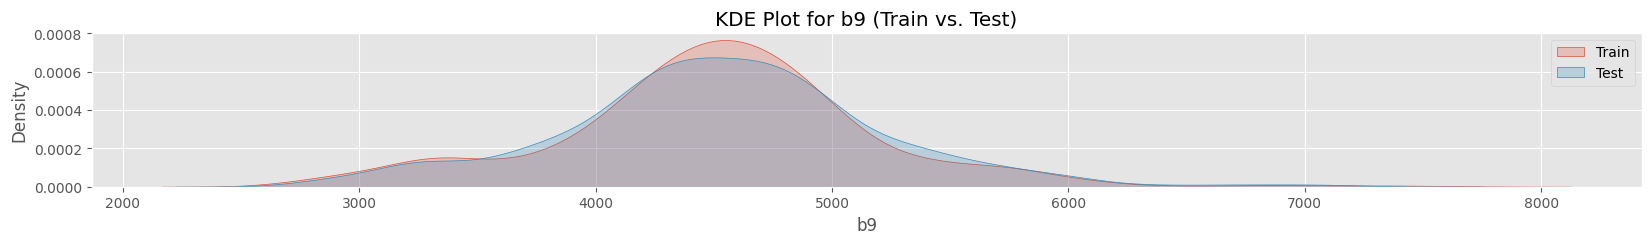

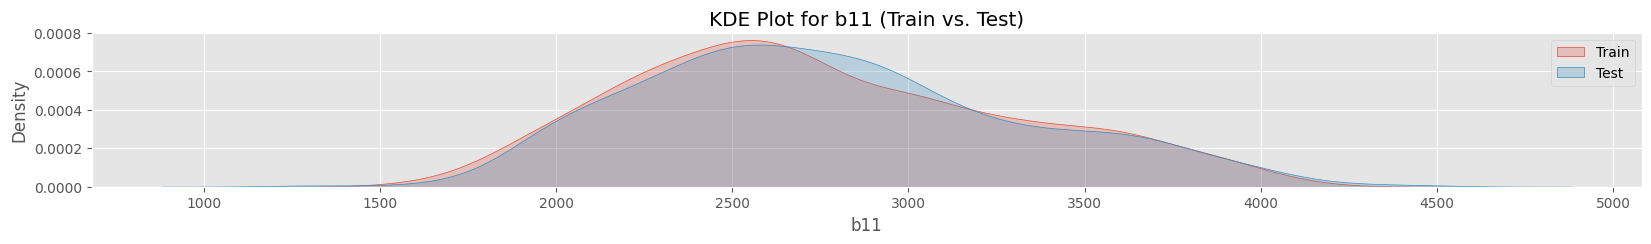

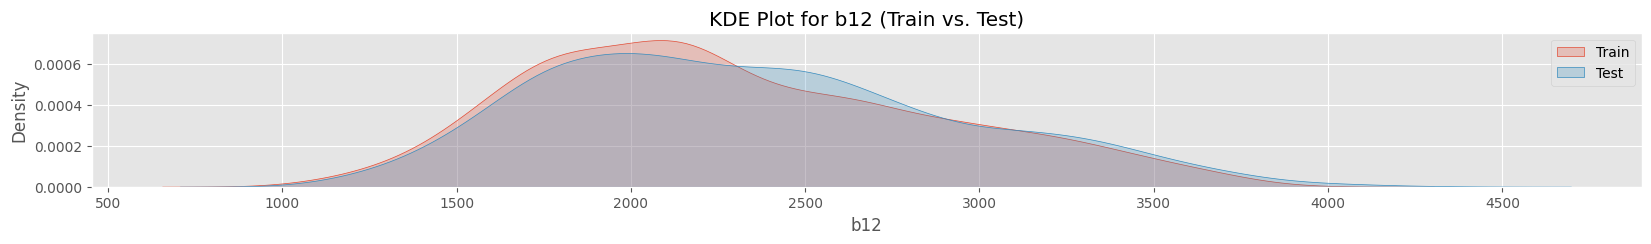

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_kde_train_test(train_data, test_data, column_name):
    plt.figure(figsize=(20, 2))
    
    # Plot KDE for train data
    sns.kdeplot(train_data[column_name], label="Train", shade=True)
    
    # Plot KDE for test data
    sns.kdeplot(test_data[column_name], label="Test", shade=True)
    
    plt.title(f"KDE Plot for {column_name} (Train vs. Test)")
    plt.xlabel(column_name)
    plt.ylabel("Density")
    
    plt.legend()
    plt.show()

# Example usage:
# plot_kde_train_test(train, test, "your_column_name")
for column in numeric_cols:
    plot_kde_train_test(train,test,column)

**BOX PLOTS - NUMERICAL**

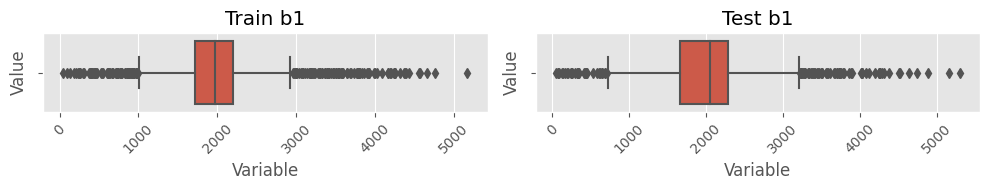

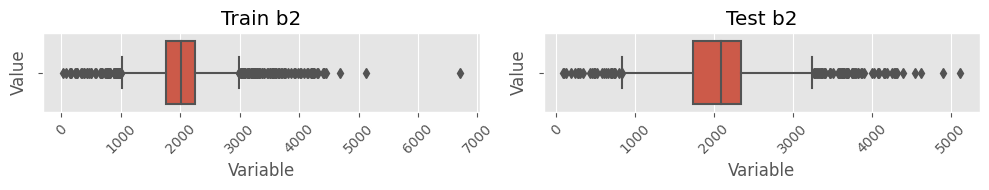

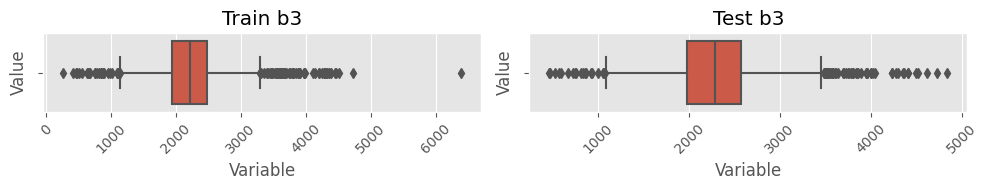

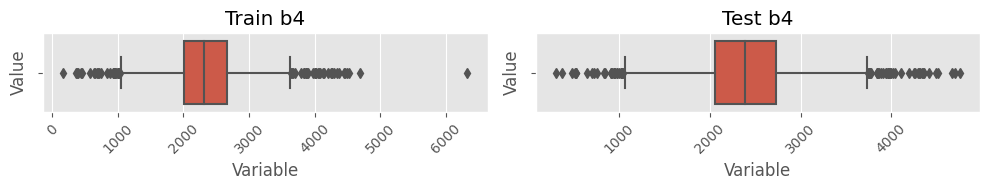

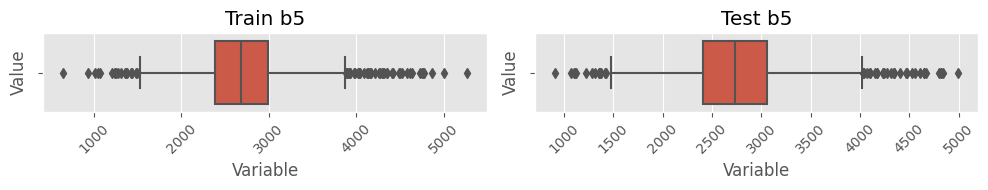

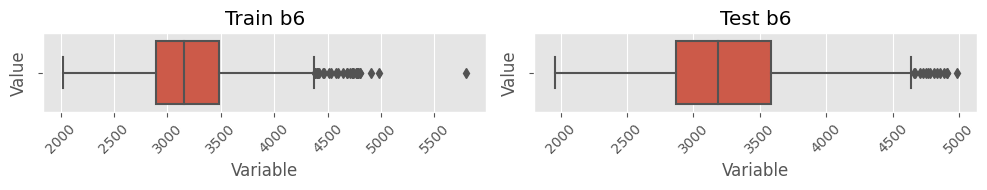

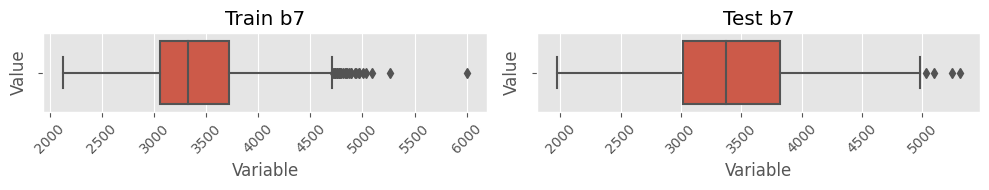

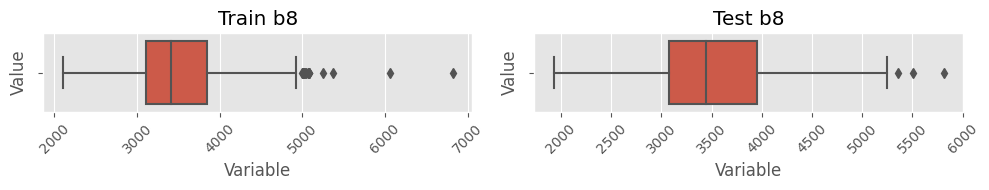

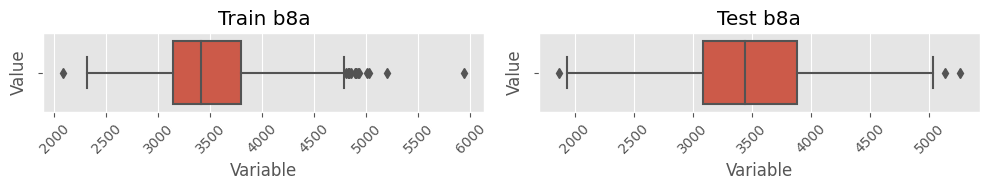

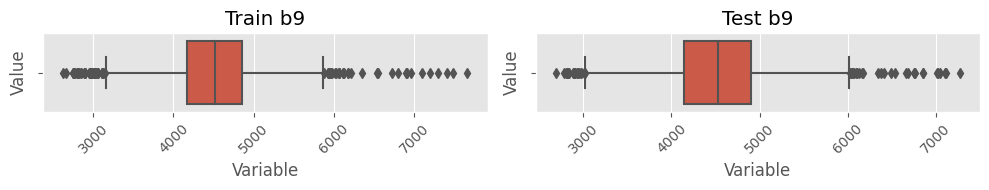

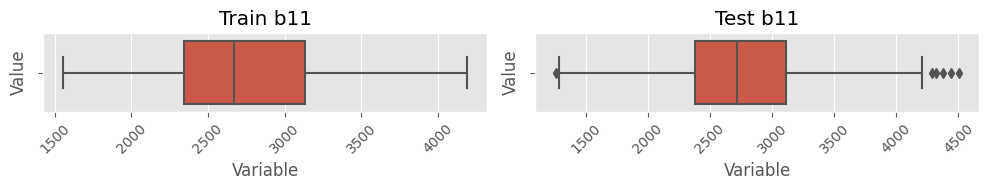

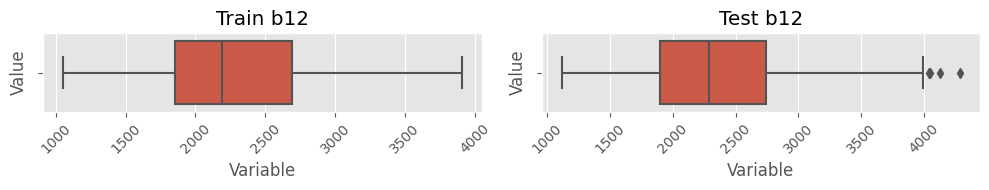

In [20]:
for column in numeric_cols:
    if train[column].dtype in [int, float]:
        plt.figure(figsize=(10, 2))
        plt.subplot(1, 2, 1)  # Create a subplot for train data
        #plt.boxplot(x=train[column])
        sns.boxplot(x=train[column])
        plt.title(f"Train {column}")
        plt.xlabel("Variable")
        plt.ylabel("Value")
        plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees

        plt.subplot(1, 2, 2)  # Create a subplot for test data
        #plt.boxplot(test[column])
        sns.boxplot(x=test[column])
        plt.title(f"Test {column}")
        plt.xlabel("Variable")
        plt.ylabel("Value")
        plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees

        plt.tight_layout()  # Adjust spacing between subplots
        plt.show()

**VIOLIN PLOTS - NUMERICAL**

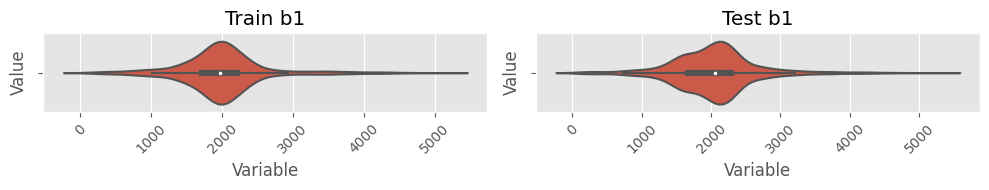

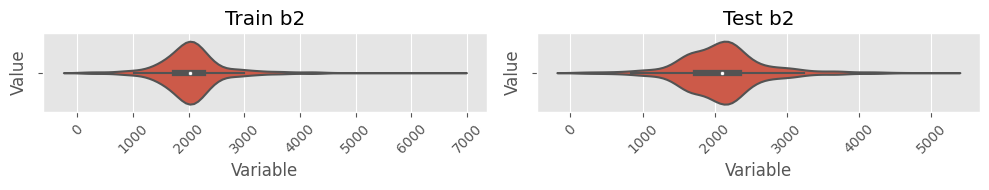

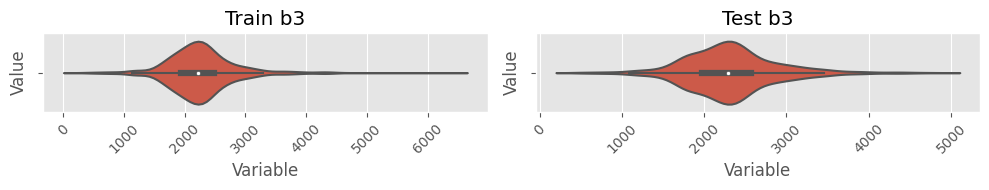

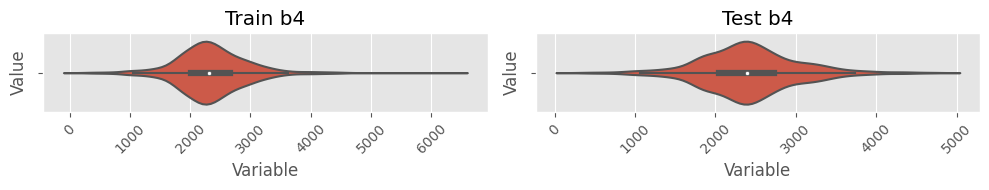

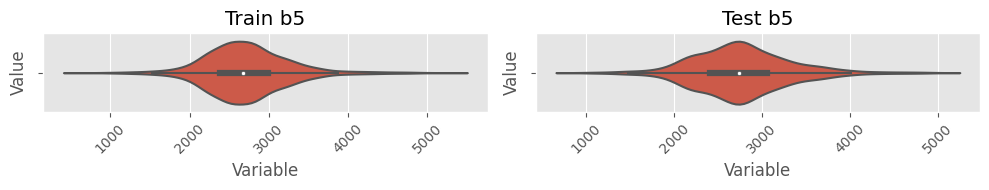

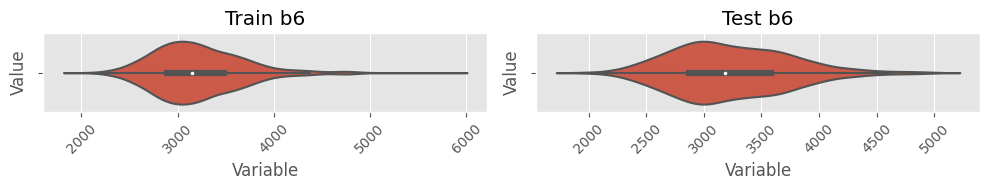

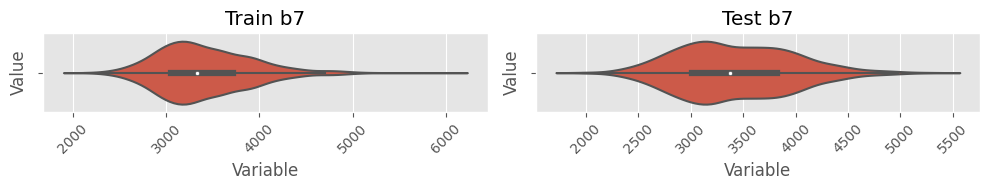

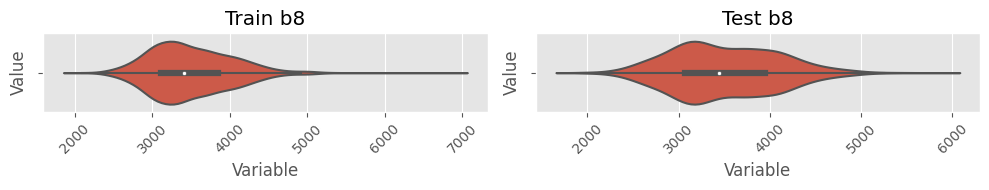

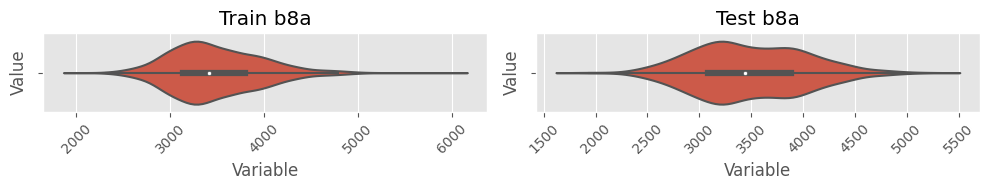

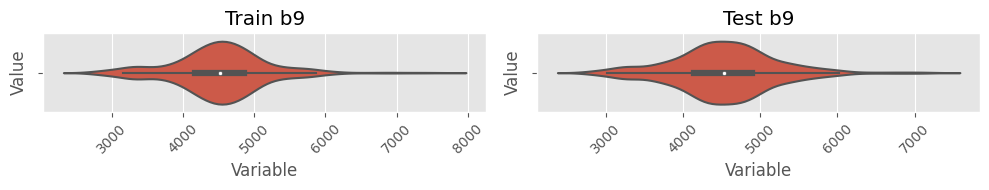

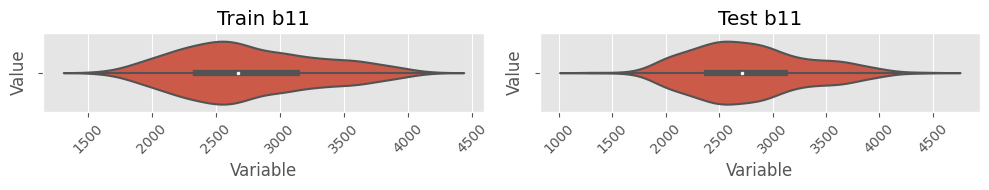

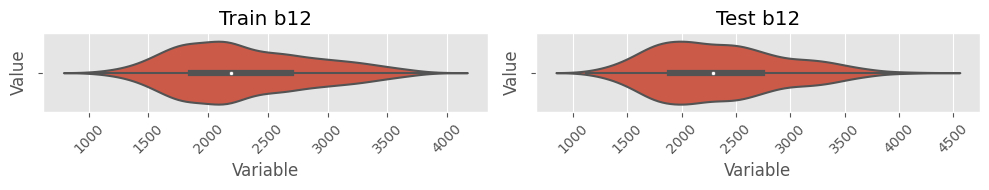

In [21]:
for column in numeric_cols:
    if train[column].dtype in [int, float]:
        plt.figure(figsize=(10, 2))
        plt.subplot(1, 2, 1)  # Create a subplot for train data
        #plt.violinplot(train[column].values)
        sns.violinplot(x=train[column])
        plt.title(f"Train {column}")
        plt.xlabel("Variable")
        plt.ylabel("Value")
        plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees

        plt.subplot(1, 2, 2)  # Create a subplot for test data
        #plt.violinplot(test[column])
        sns.violinplot(x=test[column])
        plt.title(f"Test {column}")
        plt.xlabel("Variable")
        plt.ylabel("Value")
        plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees

        plt.tight_layout()  # Adjust spacing between subplots
        plt.show()

**ADVERSERIAL VALIDATION**

In [22]:
categorical_cols=train.select_dtypes(["object"]).columns.tolist()
categorical_cols=[col for col in categorical_cols if col not in ["id","target"]]
#categorical_cols=[col for col in categorical_cols if col  in ["id",'time']]

# Initialize LabelEncoder
label_encoder = LabelEncoder()
for col in categorical_cols:
    train[col]= label_encoder.fit_transform(train[col])
    test[col]= label_encoder.fit_transform(test[col]) 
#"""

In [23]:
train["IStrain"]=1
test["IStrain"]=0
combined_df=pd.concat([train,test]) 
combined_df.drop('id',axis=1,inplace=True)
train.drop('IStrain',axis=1,inplace=True)
test.drop('IStrain',axis=1,inplace=True)

y = combined_df['IStrain']
X = combined_df[[
                    #'lat',
                     #'lon',
                     'b1',
                     'b2',
                     'b3',
                     'b4',
                     'b5',
                     'b6',
                     'b7',
                     'b8',
                     'b8a',
                     'b9',
                     'b11',
                     'b12',
                     #'location',
                     #'country',
                     #'lati',
                     #'long',
                     #'place_name',
                     #'state',
                     #'county',
                     #'cc',
                    ]]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=seed)

model = LGBMClassifier(random_state=seed) 
model.fit(X_train, y_train)
# Predict the probabilities of being in the train set for the validation data
valid_pred_proba = model.predict_proba(X_valid)[:, 1]

# Calculate the ROC-AUC score for adversarial validation
roc_auc = roc_auc_score(y_valid, valid_pred_proba)
print("Adversarial Validation ROC-AUC Score:", roc_auc)

Adversarial Validation ROC-AUC Score: 0.6357737308192313


Top 10 Features:
b1
b9
b11
b12
b8
b8a
b5
b6
b4
b7
Adversarial Validation ROC-AUC Score: 0.6357737308192313


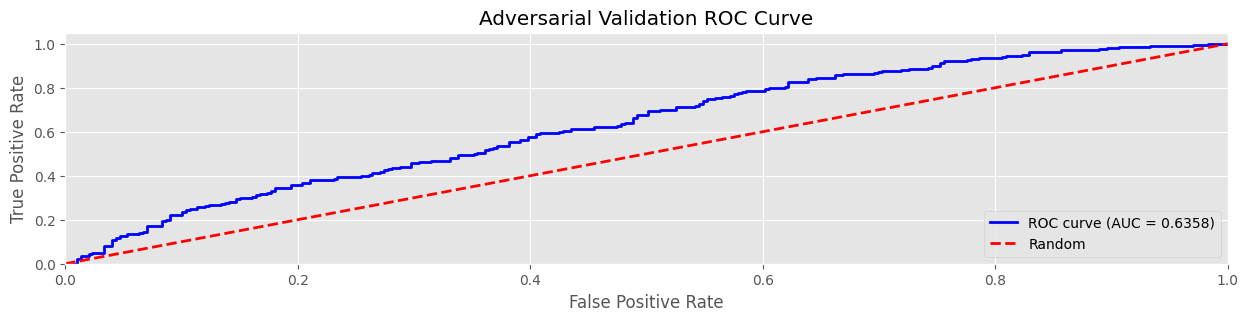

In [24]:
model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)
feature_importances = model.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]
top_10_features = sorted_indices[:10]
print("Top 10 Features:")
for feature_index in top_10_features:
    print(X_train.columns[feature_index])
    pass

#Predict the probabilities of being in the train set for the validation data
valid_pred_proba = model.predict_proba(X_valid)[:, 1]
roc_auc = roc_auc_score(y_valid, valid_pred_proba)
print("Adversarial Validation ROC-AUC Score:", roc_auc)
fpr, tpr, _ = roc_curve(y_valid, valid_pred_proba)

#Plot the ROC curve
plt.figure(figsize=(15, 3))
plt.plot(fpr, tpr, color='b', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Adversarial Validation ROC Curve')
plt.legend(loc='lower right')

**HISTOGRAMS**

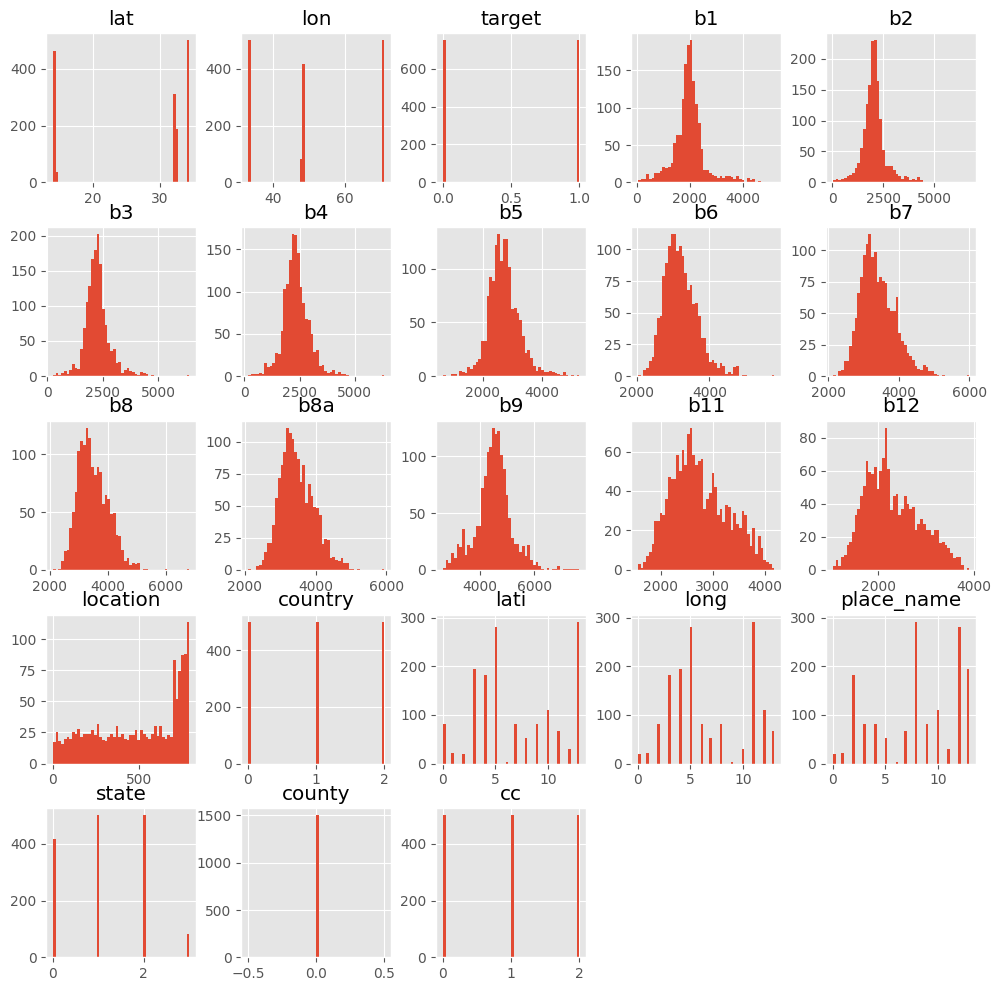

In [25]:
#overall
train.hist(bins=50, figsize=(12, 12))
plt.show()

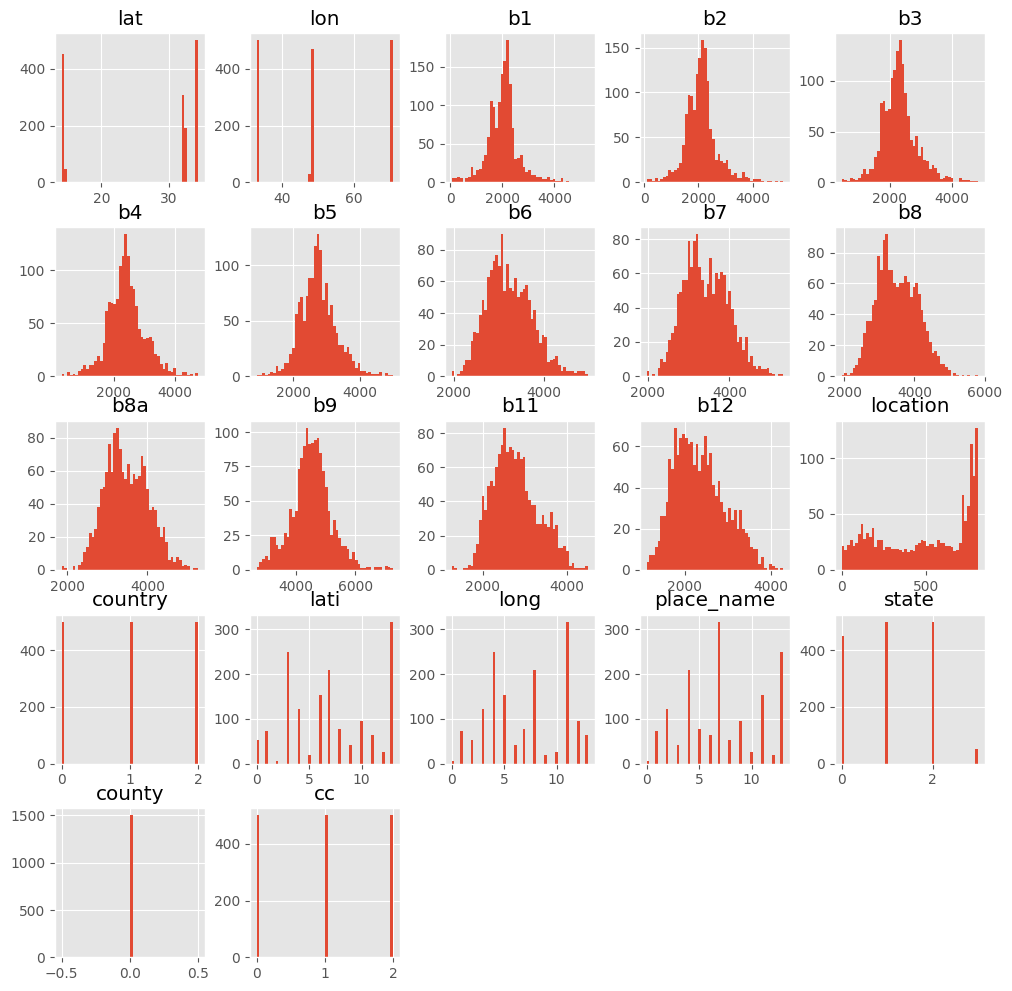

In [26]:
#overall
test.hist(bins=50, figsize=(12, 12))
plt.show()

**PAIR PLOT**

In [27]:
#sns.pairplot(train, vars=train.columns.tolist()) #['Year of manufacture', 'Mileage', 'Engine Size']
#plt.show()

In [28]:
#sns.pairplot(test, vars=test.columns.tolist()) #['Year of manufacture', 'Mileage', 'Engine Size']
#plt.show()

**CORRELATION MATRIX**

In [29]:
# Top 20 correlated features to the target
top20_corrs = abs(train.corr()['target']).sort_values(ascending = False).head(20)
top20_corrs

target        1.000000e+00
b12           4.050785e-01
b11           3.787129e-01
b4            3.256342e-01
b5            3.115550e-01
b3            2.607693e-01
b2            2.149803e-01
b8a           1.605335e-01
b1            1.569077e-01
b8            1.511260e-01
b7            1.487045e-01
place_name    1.443392e-01
b9            1.257153e-01
lati          3.781864e-02
b6            2.827157e-02
location      2.037343e-02
long          1.449320e-02
lat           1.094700e-03
lon           3.547781e-04
country       7.097843e-16
Name: target, dtype: float64

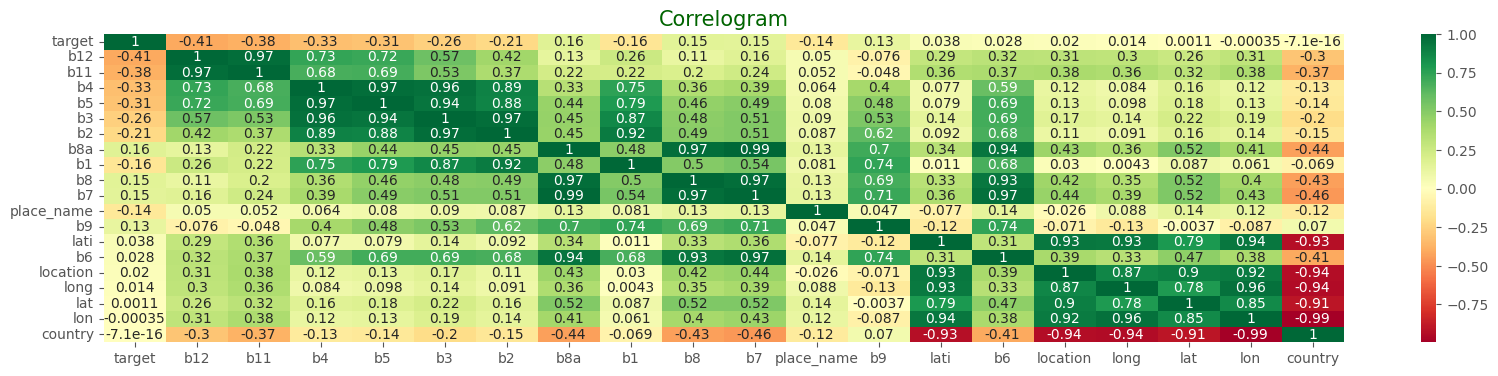

In [30]:
# Quantify correlations between features
corr = train[list(top20_corrs.index)].corr()
plt.figure(figsize = (20, 4))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

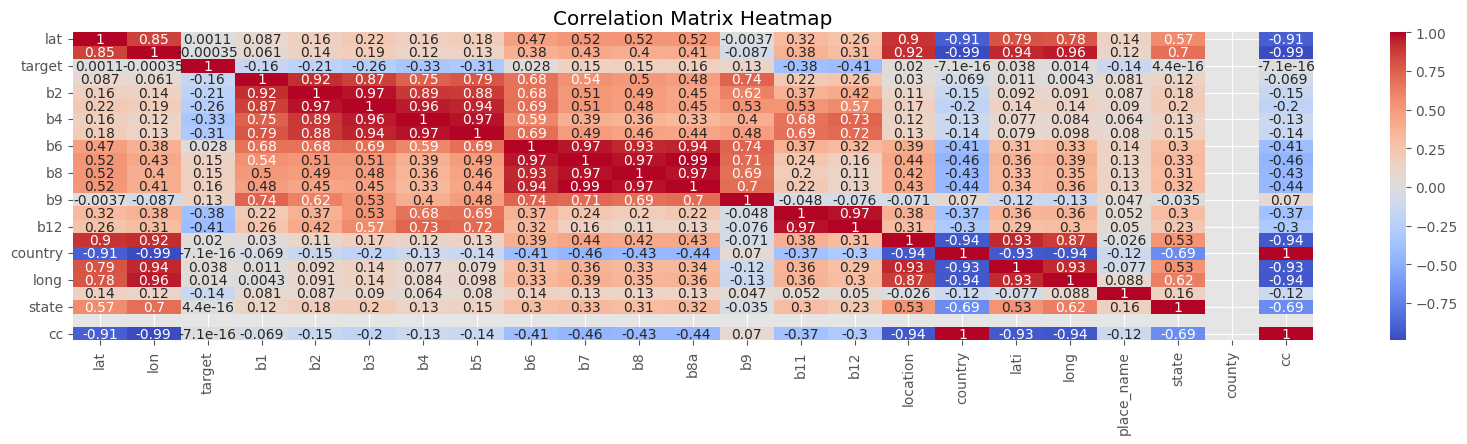

In [31]:
#train
plt.figure(figsize=(20, 4))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

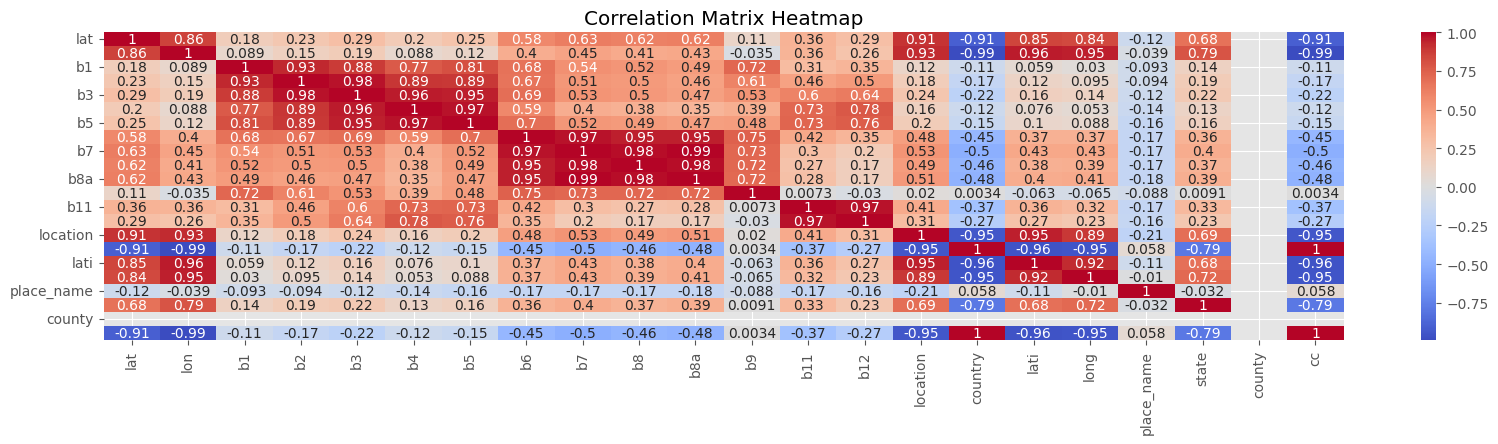

In [32]:
#overall
plt.figure(figsize=(20, 4))
sns.heatmap(test.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [33]:
def assessment(f_data, f_y_feature, f_x_feature, f_index=-1):
    """
    Develops and displays a histogram and a scatter plot for a dependent / independent variable pair from
    a dataframe and, optionally, highlights a specific observation on the plot in a different color (red).
    
    Also optionally, if an independent feature is not informed, the scatterplot is not displayed.
    
    Keyword arguments:
    
    f_data      Tensor containing the dependent / independent variable pair.
                Pandas dataframe
    f_y_feature Dependent variable designation.
                String
    f_x_feature Independent variable designation.
                String
    f_index     If greater or equal to zero, the observation denoted by f_index will be plotted in red.
                Integer
    """
    for f_row in f_data:
        if f_index >= 0:
            f_color = np.where(f_data[f_row].index == f_index,'r','g')
            f_hue = None
        else:
            f_color = 'b'
            f_hue = None
    
    f_fig, f_a = plt.subplots(1, 2, figsize=(10,2))
    
    f_chart1 = sns.distplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='orangered')
    f_chart1.set_xlabel(f_x_feature,fontsize=10)
    
    if f_index >= 0:
        f_chart2 = plt.scatter(f_data[f_x_feature], f_data[f_y_feature], c=f_color, edgecolors='w')
        f_chart2 = plt.xlabel(f_x_feature, fontsize=10)
        f_chart2 = plt.ylabel(f_y_feature, fontsize=10)
    else:
        f_chart2 = sns.scatterplot(x=f_x_feature, y=f_y_feature, data=f_data, hue=f_hue, legend=False)
        f_chart2.set_xlabel(f_x_feature,fontsize=10)
        f_chart2.set_ylabel(f_y_feature,fontsize=10)

    plt.show()


def correlation_map(f_data, f_feature, f_number):
    """
    Develops and displays a heatmap plot referenced to a primary feature of a dataframe, highlighting
    the correlation among the 'n' mostly correlated features of the dataframe.
    
    Keyword arguments:
    
    f_data      Tensor containing all relevant features, including the primary.
                Pandas dataframe
    f_feature   The primary feature.
                String
    f_number    The number of features most correlated to the primary feature.
                Integer
    """
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    
    with sns.axes_style("white"):
        f_fig, f_ax = plt.subplots(figsize=(40, 20))
        f_map = sns.heatmap(f_correlation, mask=f_mask, vmin=-1, vmax=1, square=True,
                            center=0, cmap="RdYlBu")
    #plt.show()

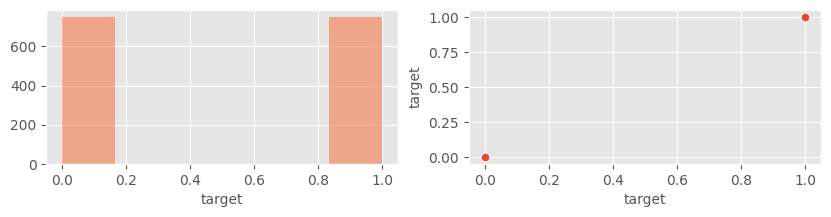

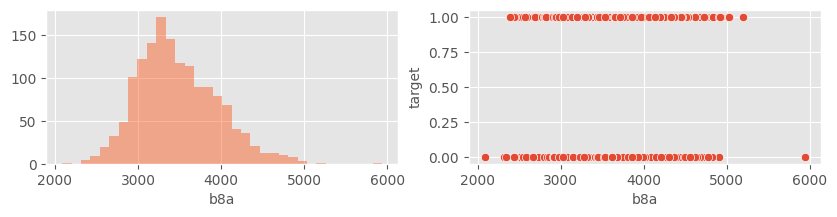

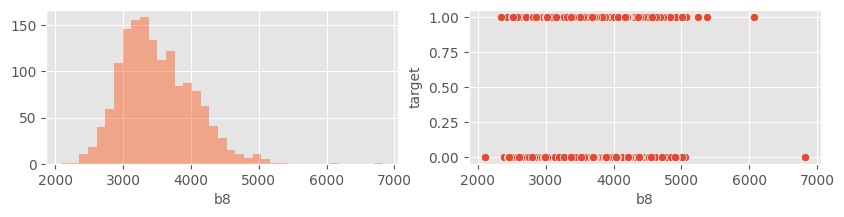

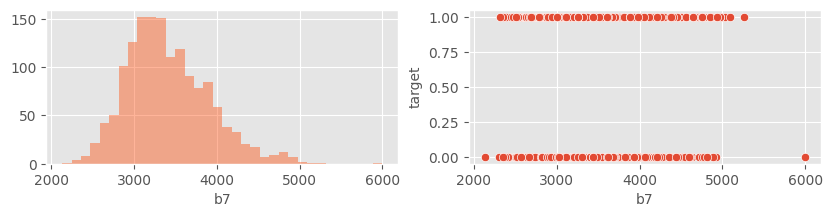

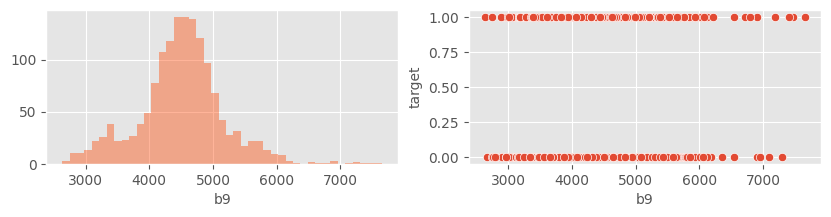

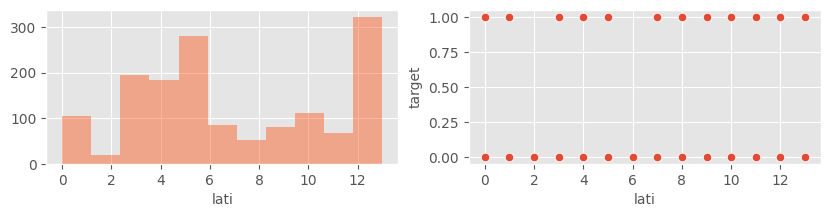

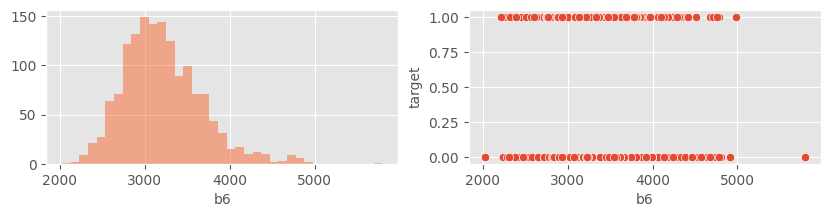

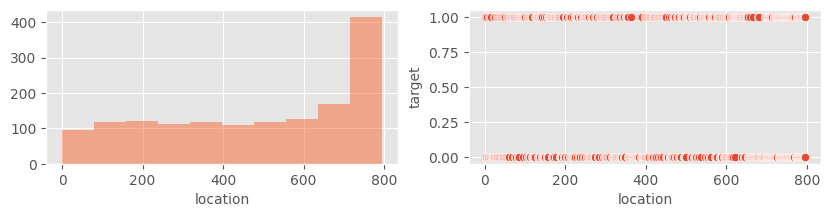

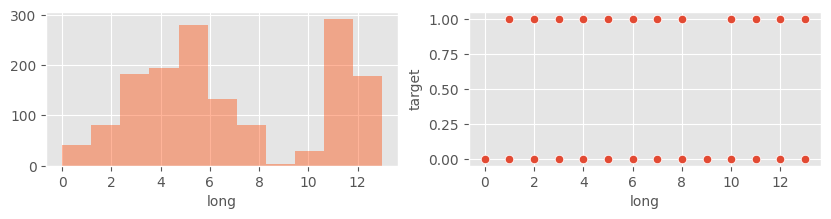

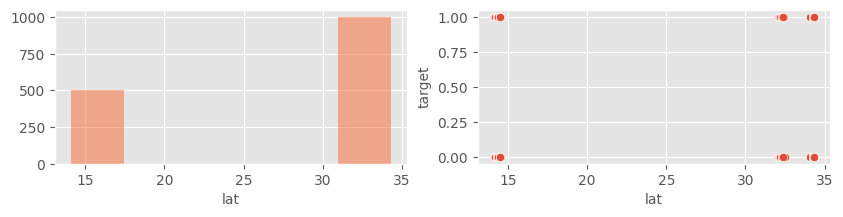

In [34]:
most_correlated_features = train.corr().nlargest(10,'target')['target'].index

for column in most_correlated_features:
    assessment(train, 'target', column, -1)
    pass

In [35]:
highly_correlated_feature_pairs = []
highly_correlated_features_to_drop = []

correlation_matrix = train.corr().abs()
upper_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
for row in range(upper_matrix.shape[0]):
    for column in range(upper_matrix.shape[1]):
        if upper_matrix.iloc[row, column] > 0.95:
            highly_correlated_feature_pairs.append([row, column, upper_matrix.iloc[row, column]])
            
print(f'Number of highly intercorrelated feature pairs: {len(highly_correlated_feature_pairs)}')

highly_correlated_feature_pairs = pd.DataFrame(highly_correlated_feature_pairs).sort_values(by=[2], ascending=False)
highly_correlated_feature_pairs.columns = ['feature_1', 'feature_2', 'correl']
highly_correlated_feature_pairs.head(10)

Number of highly intercorrelated feature pairs: 12


feature_1  feature_2    correl
11         16         22  1.000000
0           1         16  0.993714
2           1         22  0.993714
8           9         11  0.992801
3           4          5  0.974414
9          10         11  0.974407
7           9         10  0.974051
10         13         14  0.972636
5           6          7  0.972013
6           8          9  0.965287

In [36]:
highly_correlated_features_to_drop = [column for column in upper_matrix.columns if any(upper_matrix[column] > 0.95)]
train = train.drop(train[highly_correlated_features_to_drop], axis=1)

nr_features = train.shape[1] - 1
print(f'Optimized number of features: {nr_features}')
print('--'*62)
train.head()

Optimized number of features: 13
----------------------------------------------------------------------------------------------------------------------------


id        lat        lon  target           b1           b2  \
0  ID_JRBSKS8MYPU6  14.113252  33.314202       0  2268.375000  2224.791667   
1  ID_K5SS5L8BA8TF  14.110377  33.333426       1  2249.958333  2350.930556   
2  ID_KM39ZSIZCC5A  14.112084  33.347350       0  2336.791667  2297.125000   
3  ID_ERVODRIN6NQJ  14.119091  33.237935       0  2451.972222  2420.555556   
4  ID_6U9MY0ASQUWB  14.124840  33.435654       1  1928.444444  1975.388889   

            b6           b9          b11  location  lati  place_name  state  \
0  2766.319444  4256.152778  2518.416667         0     0           9      3   
1  3190.569444  4688.069444  2635.597222         1     0           9      3   
2  2806.583333  4285.972222  2490.958333         2     0           9      3   
3  3586.111111  5214.083333  3895.416667         3     0           9      3   
4  2795.208333  4251.500000  2288.694444         4     0           9      3   

   county  
0       0  
1       0  
2       0  
3       0  
4       0

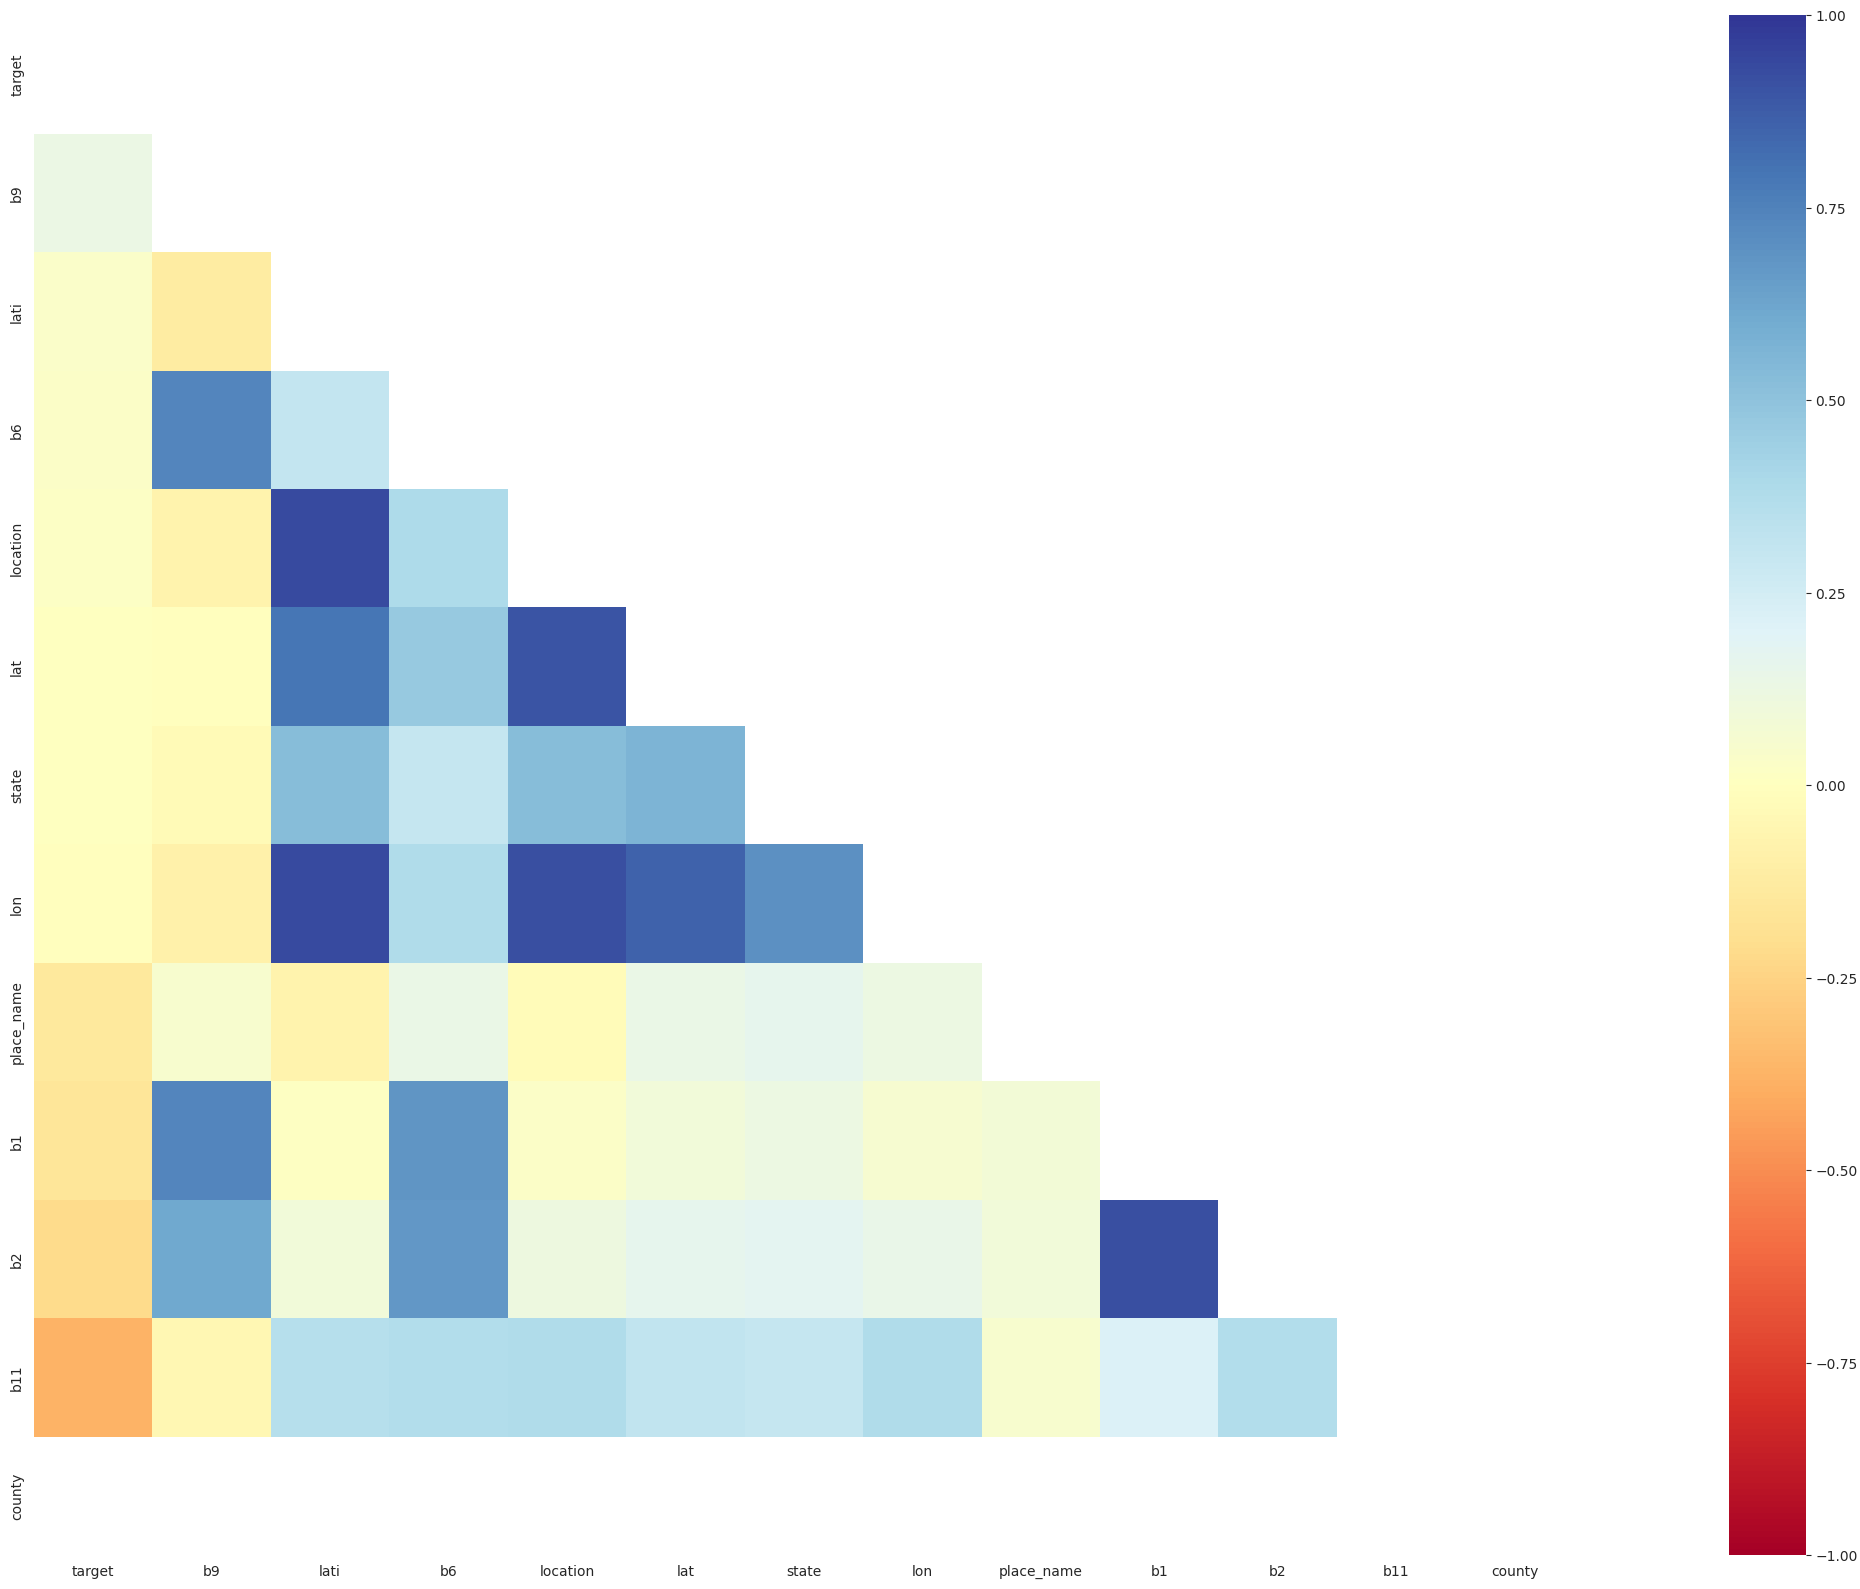

In [37]:
correlation_map(train, 'target', nr_features)